In [1]:
# Import the necessary libraries

import tensorflow as tf
import matplotlib.pyplot as plt


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten,Dropout, Dense,Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

import tensorflow_datasets as tfds
import numpy as np
import os

# Loading and Understanding the Data

In [2]:
#load the dataset

(ds_train,ds_test), ds_info = tfds.load(
    "malaria",
    split = ['train[:80%]', 'train[80%:]'],
    shuffle_files = True,
    as_supervised = True,
    with_info = True
)



In [3]:
#Understand the data
ds_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='C:\\Users\\Administrator\\tensorflow_datasets\\malaria\\1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection 

In [4]:
print(ds_info.name)  # Print the name of the dataset
print(ds_info.description)  # Print the description of the dataset
print(ds_info.features)  # Print information about dataset features
print(ds_info.splits) # Print information about dataset splits ( ds_train, ds_test)

malaria
The Malaria dataset contains a total of 27,558 cell images with equal instances
of parasitized and uninfected cells from the thin blood smear slide images of
segmented cells.
FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
})
{'train': <SplitInfo num_examples=27558, num_shards=4>}


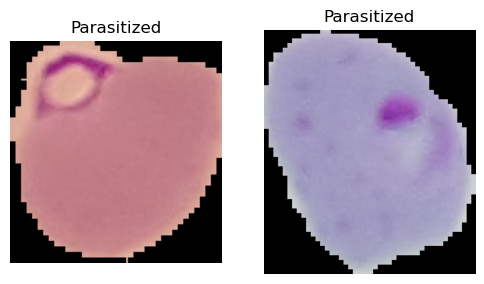

In [5]:
# Function to take samples and convert to list
def get_samples(dataset, n_samples=20):
    return [(image.numpy(), label.numpy()) for image, label in dataset.take(n_samples)]

# Getting samples
samples = get_samples(ds_train)

# Filtering out samples with label 0 (Parasitized)
infect = [sample for sample in samples if sample[1] == 0]

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(6, 5))
for i, ax in enumerate(axs):
    ax.imshow(infect[i][0])
    ax.set_title("Parasitized" if infect[i][1] == 0 else "Uninfected")
    ax.axis('off')

plt.show()

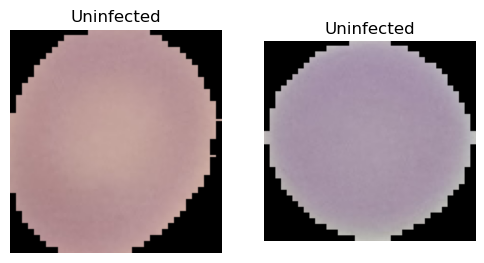

In [6]:
# Function to take samples and convert to list
def get_samples(dataset, n_samples=20):
    return [(image.numpy(), label.numpy()) for image, label in dataset.take(n_samples)]

# Getting samples
samples = get_samples(ds_train)

# Filtering out samples with label 1 (Uninfected)
uninfected = [sample for sample in samples if sample[1] == 1]

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(6, 5))
for i, ax in enumerate(axs):
    if i < len(uninfected):  # Check if there are enough uninfected samples to display
        ax.imshow(uninfected[i][0])
        ax.set_title("Uninfected")
        ax.axis('off')
    else:
        ax.set_visible(False)  # Hide axes if there are not enough samples

plt.show()

# Exploratory Data Analysis

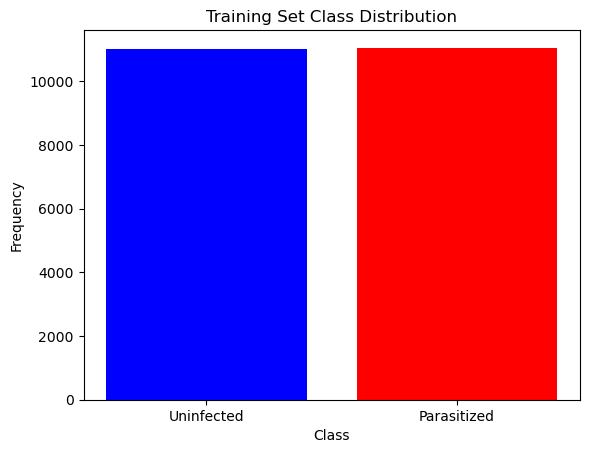

In [7]:
#Exploratory data analysis -is our data balanced?
import matplotlib.pyplot as plt

def plot_class_distribution(dataset,title):
    labels = np.array([label.numpy() for _, label in dataset])
    unique, counts = np.unique(labels, return_counts=True)
    plt.bar(unique, counts, color= ["blue","red"])
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.xticks(unique, ['Uninfected', 'Parasitized'])  # This is based on class labels
    plt.show()

plot_class_distribution(ds_train, 'Training Set Class Distribution')


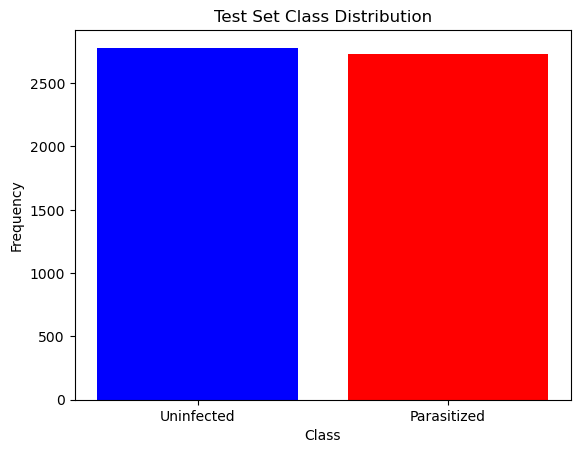

In [8]:
plot_class_distribution(ds_test, 'Test Set Class Distribution')

# Data PreProcessing

In [9]:
#Data preprocessing
def preprocess_images(image, label):
    image = tf.cast(image, tf.float32)/255.0 #normalize the images to [0, 1]
    image = tf.image.resize(image, [128,128]) #resizing the images
    #image = tf.image.convert_image_dtype(image, tf.float32) # Normalize images to [0, 1]
    #image = tf.image.resize(image, [128, 128]) # Resize images
    
    return image, label

In [10]:
# Applying the preprocessing to our dataset

ds_train = ds_train.map(preprocess_images).cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess_images).batch(32).cache().prefetch(tf.data.AUTOTUNE)

# Creating/Building the Model

In [12]:
#Creating the model

model = Sequential([
    Input(shape=(128, 128, 3)),
    Conv2D(32,3,padding ="same", activation = "relu", input_shape =(128,128,3)),
    MaxPooling2D(),
    Conv2D(64,3, padding ="same", activation ="relu"),
    MaxPooling2D(),
    Conv2D(128,3,padding ="same", activation = "relu"),
    MaxPooling2D(),
    Flatten(),
    Dropout(0.5),
    Dense(256, activation = "relu"),
    Dense(1, activation = "sigmoid")]
    
)

model.compile(
    optimizer ="adam",
    loss = "binary_crossentropy",
    metrics =["accuracy"]
)

In [13]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,482,369 (32.36 MB)

 Trainable params: 8,482,369 (32.36 MB)

 Non-trainable params: 0 (0.00 B)

## Model Training 

In [14]:
#Training the model
history = model.fit(
    
    ds_train,
    validation_data = ds_test,
    epochs = 10

)

Epoch 1/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 316s 453ms/step - accuracy: 0.6504 - loss: 0.6070 - val_accuracy: 0.9209 - val_loss: 0.2332
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 326s 473ms/step - accuracy: 0.9473 - loss: 0.1644 - val_accuracy: 0.9526 - val_loss: 0.1585
Epoch 3/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 321s 466ms/step - accuracy: 0.9576 - loss: 0.1286 - val_accuracy: 0.9572 - val_loss: 0.1412
Epoch 4/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 321s 466ms/step - accuracy: 0.9634 - loss: 0.1089 - val_accuracy: 0.9574 - val_loss: 0.1476
Epoch 5/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 320s 464ms/step - accuracy: 0.9654 - loss: 0.1051 - val_accuracy: 0.9546 - val_loss: 0.1426
Epoch 6/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 319s 463ms/step - accuracy: 0.9701 - loss: 0.0908 - val_accuracy: 0.9561 - val_loss: 0.1640
Epoch 7/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 273s 396ms/step - accuracy: 0.9722 - loss: 0.0804 - val_accuracy: 0.9594 - val_loss: 0.1627
Epoch 8/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 234s 339ms/step - accuracy: 0.9743 -

In [15]:
#Evaluating the model

test_loss, test_acc = model.evaluate(ds_test)
print(f"The test accuracy for our model is: {test_acc * 100:.2f}%")

173/173 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.9555 - loss: 0.2125
The test accuracy for our model is: 95.63%


In [16]:
model.save("malaria_model.keras")

## Results

In [17]:

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Function to prepare the labels, that is if ds_test does not return them directly

def get_true_labels(dataset):
    labels = []
    for images, labels_batch in dataset:
        labels.extend(labels_batch.numpy())
    return np.array(labels)

# Predict the probabilities and then convert them to class labels
predictions_prob = model.predict(ds_test)
predictions = (predictions_prob > 0.5).astype(int)

# Extract the true labels
true_labels = get_true_labels(ds_test)

# Compute confusion matrix
cm = confusion_matrix(true_labels, predictions)



173/173 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step


Confusion matrix


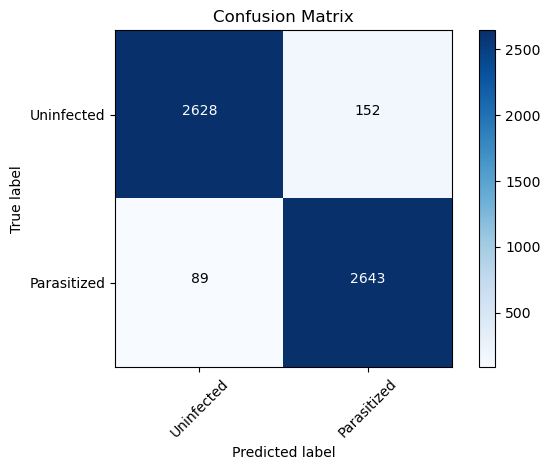

In [19]:
# Function to plot confusion matrix
import itertools
"""
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Plot non-normalized confusion matrix
plot_confusion_matrix(cm, classes=['Uninfected', 'Parasitized'],
                      title='Confusion Matrix')

plt.show()


In [21]:
from sklearn.metrics import classification_report

# 'predictions' contains model predictions and
# 'true_labels' contains the actual labels.
true_labels = [label.numpy() for image, label in ds_test.unbatch()]
classification_report = classification_report(true_labels, predictions, target_names=['Uninfected', 'Parasitized'])

print(classification_report)


              precision    recall  f1-score   support

  Uninfected       0.97      0.95      0.96      2780
 Parasitized       0.95      0.97      0.96      2732

    accuracy                           0.96      5512
   macro avg       0.96      0.96      0.96      5512
weighted avg       0.96      0.96      0.96      5512



# Thank you